In [1]:
import os
import random
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Optional, Callable
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_segmentation_masks
from zipfile import ZipFile
import glob

In [2]:
_path_chest = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
_path_dsb = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
_path_histo = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
_path_ranzcr = "/home/data/02_SSD4TB/suzy/datasets/public/ranzcr-clip-catheter-line-classification"
_path_retina = "/home/data/02_SSD4TB/suzy/datasets/public/aptos2019-blindness-detection"

In [5]:
# HistocancerDataset

In [3]:
kaggle_biodatasets = [
    "aptos2019-blindness-detection",
    "chest-xray-pneumonia",
    "data-science-bowl-2018",
    "histopathologic-cancer-detection",
    "intel-mobileodt-cervical-cancer-screening",
    "ranzcr-clip-catheter-line-classification",
    "skin-cancer-mnist"
]


def download_datasets(tag, path="."):
    """Helper function to download datasets

    Parameters
    ----------
    tag : str
        tag for dataset

        .. note::
            available tags:
            kaggle_biodatasets = [
                "aptos2019-blindness-detection",
                "chest-xray-pneumonia",
                "data-science-bowl-2018",
                "histopathologic-cancer-detection",
                "intel-mobileodt-cervical-cancer-screening",
                "ranzcr-clip-catheter-line-classification",
                "skin-cancer-mnist"
            ]
    path : str, optional
        path where to save dataset, by default "."
    Examples
    ----------
    >>> download_datasets(tag="skin-cancer-mnist", path=".")
    """
    if tag == "chest-xray-pneumonia":
        bash_c_tag = ["kaggle", "datasets", "download",
                      "-d", "paultimothymooney/chest-xray-pneumonia"]
    elif tag == "skin-cancer-mnist":
        bash_c_tag = ["kaggle", "datasets", "download",
                      "-d", "kmader/skin-cancer-mnist-ham10000"]
    else:
        bash_c = ["kaggle", "competitions", "download", "-c"]
        bash_c_tag = bash_c.copy()
        bash_c_tag.append(tag)

    prev_cwd = os.getcwd()
    os.chdir(path)
    process = subprocess.Popen(bash_c_tag, stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)

    os.chdir(prev_cwd)


def extract_zip(fzip, fnew=None):
    with ZipFile(fzip, 'r') as zip:  # ZipFile(fzip, 'r') as zip:
        print('Extracting all the train files now...')
        zip.extractall(fnew)
        print('Done!')

        
class RANZCRDataset(Dataset):
    r"""PyTorch friendly RANZCRDataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and catheters presence, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = RANZCRDataset(_path_ranzcr, show=True, shape=512)

    .. image:: ../imgs/RANZCRDataset.png
        :width: 600

    References
    ---------------
    .. [1] https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/data
    """

    def __init__(self, root: str = ".", mode: str = "train", shape: int = 256, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False, show: bool = True):
        tag = "ranzcr-clip-catheter-line-classification"

        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val, test"

        self.mode = mode

        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            path = os.path.join(root,tag)
        else:
            path = root

        train_path = os.path.join(path, "train")
        test_path = os.path.join(path, "test")
        csv_path = os.path.join(path, "train_annotations.csv")

        self.data = pd.read_csv(csv_path)
        self.labels, self.encoded_labels = self.get_labels()
        self.train_list, self.valid_list = self.get_train_valid(train_path)
        self.shape = shape

        if transform is None:
            self.transform = self.default_transform()
        else:
            self.transform = transform

        if target_transform is not None:
            self.target_transform = target_transform

        if self.mode != "test":
            if self.mode == "train":
                self.file_list = self.train_list
            else:
                self.file_list = self.valid_list
        else:
            self.file_list = glob.glob(test_path+"/*")

        if show:
            self.visualize_batch()

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        if self.mode != "test":
            img_path = self.file_list[idx][0]
            fname = img_path.split("/")[-1]
        else:
            img_path = self.file_list[idx]
            fname = img_path.split("/")[-1]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        if self.mode != "test":
            label = self.file_list[idx][1]
            sample = (img, label, fname)
        else:
            sample = (img, fname)

        return sample

    def default_transform(self):
        transform = transforms.Compose([
            transforms.Resize((self.shape, self.shape)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        return transform

    def visualize_batch(self):
        loader = DataLoader(self, batch_size=4, shuffle=True)
        
        if self.mode != "test":
            imgs, labels, fnames = next(iter(loader))
        else:
            imgs, fnames = next(iter(loader))
            labels = None

        list_imgs = [imgs[i] for i in range(len(imgs))]
        self.show(list_imgs, fnames, labels)

    def show(self, imgs, fnames, labels=None):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * img + mean
            inp = np.clip(inp, 0, 1)
            
            axs[0, i].imshow(np.asarray(inp))
            axs[0, i].set(xticklabels=[], yticklabels=[],
                          xticks=[], yticks=[])
            axs[0, i].set_title("..."+fnames[i][-11:-4])

            if self.mode != "test":
                lab = self.unique_labels[labels[i]]
                axs[0, i].text(0, -0.2, str(int(labels[i])) +
                           ": " + lab, transform=axs[0, i].transAxes)

    def get_labels(self):
        self.data = self.data.drop(["data"], axis=1)

        data_org = self.data['label']
        labels = data_org.to_list()

        used = set()
        self.unique_labels = [
            x for x in labels if x not in used and (used.add(x) or True)]

        ord_enc = OrdinalEncoder()
        self.data[['label']] = ord_enc.fit_transform(self.data[['label']])

        self.data.label = self.data.label.astype("int")

        label = self.data["label"]
        label = label.to_list()

        encoded_labels = label
        return labels, encoded_labels

    def get_train_valid(self, train_path):
        seed = 42
        train_list = []

        for i in self.data.index:
            a = self.data["StudyInstanceUID"].loc[i]
            b = train_path + "/" + a + ".jpg"
            train_list.append((b, self.data['label'].loc[i]))

        train_list, valid_list = train_test_split(train_list,
                                                  test_size=0.2,
                                                  random_state=seed)
        return train_list, valid_list

b'ranzcr-clip-catheter-line-classification.zip: Skipping, found more recently modified local copy (use --force to force download)\n'
Extracting all the train files now...
Done!


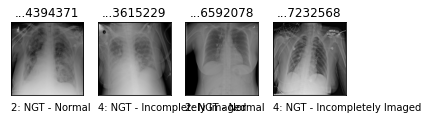

In [6]:
_path_ranzcr_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"
#_path_ranzcr
train_dataset = RANZCRDataset(_path_ranzcr_download, mode = "train", download = True)

In [5]:
len(train_dataset)

3582

In [100]:
train_test_split(range(100))

list

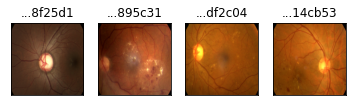

In [162]:
_path_ranzcr_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"
train_dataset = RetinopathyDataset(_path_retina, mode = "test", download = False)

In [163]:
len(train_dataset)

1928

In [ ]:
class RetinopathyDataset(Dataset):
    r"""PyTorch friendly RetinopathyDataset class

    Dataset is loaded using Kaggle API.
    For further information on raw dataset and blindness detection, please refer to [1]_.

    Examples
    ----------
    >>> train_dataset = RetinopathyDataset(".", mode="train", show=True)

    .. image:: ../imgs/RetinopathyDataset.png
        :width: 300

    References
    ---------------
    .. [1] <https://www.kaggle.com/c/aptos2019-blindness-detection/data>`_
    """

    def __init__(self, root: str = ".", mode: str = "train", shape: int = 256, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False, show: bool = True):
        tag = "aptos2019-blindness-detection"

        if download:
            download_datasets(tag, path=root)

            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            path = os.path.join(root, tag)
        else:
            path = root
        
        self.mode = mode
        
        if mode != "test":
            self.csv_path = os.path.join(path, "train.csv")
            self.img_path = os.path.join(path, "train_images")
            data = pd.read_csv(self.csv_path)
            
            train_idx, val_idx = train_test_split(range(len(data)), test_size=0.1,)
            
            train_data = data.iloc[train_idx]
            val_data = data.iloc[val_idx]
                    
            if self.mode == "train":
                self.data = train_data
                self.data.reset_index(drop=True, inplace=True)
            else:
                self.data = val_data
                self.data.reset_index(drop=True, inplace=True)
        else:
            self.img_path = os.path.join(path, "test_images")
            self.data = os.listdir(self.img_path)
        
        self.shape = shape

        if transform is None:
            self.transform = self.default_transform()
        else:
            self.transform = transform

        if target_transform is not None:
            self.target_transform = target_transform

        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode != "test":
            fname = self.data.loc[idx, 'id_code'] + ".png"
        else:
            fname = self.data[idx]

        img_name = os.path.join(self.img_path, fname)
        
        img = Image.open(img_name).convert("RGB")
        img = self.transform(img)

        if self.mode != "test":
            label = torch.tensor(self.data.loc[idx, 'diagnosis'])
            sample = (img, label, fname)
        else:
            sample = (img, fname)
        
        return sample

    def default_transform(self):
        transform = transforms.Compose([
            transforms.Resize((self.shape, self.shape)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        return transform

    def visualize_batch(self):
        loader = DataLoader(self, batch_size=4, shuffle=True)
        
        if self.mode != "test":
            imgs, labels, fnames = next(iter(loader))
        else:
            imgs, fnames = next(iter(loader))
            labels = None

        list_imgs = [imgs[i] for i in range(len(imgs))]
        self.show(list_imgs, fnames, labels)

    def show(self, imgs, fnames, labels=None):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * img + mean
            inp = np.clip(inp, 0, 1)

            axs[0, i].imshow(np.asarray(inp))
            axs[0, i].set(xticklabels=[], yticklabels=[],
                          xticks=[], yticks=[])
            axs[0, i].set_title("..."+fnames[i][-10:-4])
            
            if self.mode != "test":
                axs[0, i].text(0, -0.2, "Severity: " +
                               str(int(labels[i])), transform=axs[0, i].transAxes)

b'aptos2019-blindness-detection.zip: Skipping, found more recently modified local copy (use --force to force download)\n'
Extracting all the train files now...
Done!


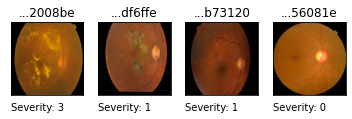

In [170]:
_path_retina_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"
#_path_retina
train_dataset = RetinopathyDataset(_path_retina_download, mode = "val", download = True)

In [171]:
print(train_dataset)

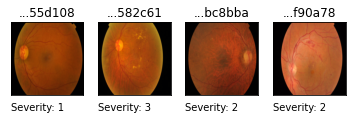

In [89]:
loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
imgs, labels, fnames = next(iter(loader))
list_imgs = [imgs[i] for i in range(len(imgs))]
show(list_imgs, labels, fnames)

In [62]:
def show(imgs, labels, fnames):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * img + mean
        inp = np.clip(inp, 0, 1)

        axs[0, i].imshow(np.asarray(inp))
        axs[0, i].set(xticklabels=[], yticklabels=[],
                      xticks=[], yticks=[])
        axs[0, i].set_title("..."+fnames[i][-6:])
        axs[0, i].text(0, -0.2, "Severity: " +
                       str(int(labels[i])), transform=axs[0, i].transAxes)

In [74]:
len(train_dataset)

3582

In [10]:
len(train_dataset)

22003

In [ ]:
len(t)

In [66]:
len(train_dataset)

57458